In [1]:
import random
import numpy as np
from model import Model_3DCNN, strip_prefix_if_present
from data_reader import Dataset_MLHDF
from img_util import GaussianFilter, Voxelizer3D
from file_util import *
import torch
import torch.nn as nn

from torch.nn.parallel import DataParallel, DistributedDataParallel
from torch.optim import Adam, RMSprop, lr_scheduler
from torch.utils.data import Dataset, DataLoader, Subset

/home/vscode/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = Dataset_MLHDF('../../data/processed/pdbbind2016_general_train.hdf', 1, '../../data/processed/general_train_3dnn.csv', is_crystal=True, rmsd_weight=0, rmsd_thres=2)
dataloader = DataLoader(dataset, batch_size=50, shuffle=True, num_workers=0, worker_init_fn=None)
voxelizer = Voxelizer3D(use_cuda=False, verbose=1)
gaussian_filter = GaussianFilter(dim=3, channels=19, kernel_size=11, sigma=1, use_cuda=False)

/home/vscode/.local/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
device = torch.device("cpu")
vol_batch = torch.zeros((50,19,48,48,48)).float().to(device)
for batch_ind, batch in enumerate(dataloader):
    x_batch, y_batch = batch
       # voxelize into 3d volume
    for i in range(x_batch.shape[0]):
        xyz, feat = x_batch[i,:,:3], x_batch[i,:,3:]
        vol_batch[i,:,:,:,:] = voxelizer(xyz, feat)
    vol_batch_gaus = gaussian_filter(vol_batch)

AttributeError: 'AxesSubplot' object has no attribute 'voxels'

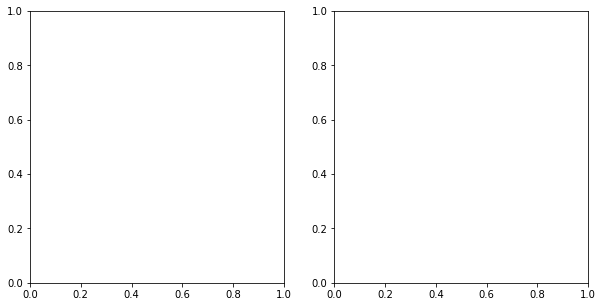

In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors

d2 = vol_batch_gaus[0][1].numpy()
d = vol_batch[0][1].numpy()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
colors = plt.cm.plasma(d)
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
ax1.voxels(d,facecolors=colors,alpha = 0.5,edgecolor='k')

m = cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
m.set_array([])
plt.colorbar(m)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

ax2.voxels(d2,facecolors=colors,alpha = 0.5,edgecolor='k')
m = cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
m.set_array([])
plt.colorbar(m)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.show()

## Quantum encoding

We etrieve blocks of (2x2x2) from the image and encode them in a quantum circuit. We explore different techniques of data encoding.

In [ ]:
d = vol_batch_gaus[0][1].numpy()

# Rolling 3D window for ND array
def roll(a,      # ND array
         b,      # rolling 2D window array
         dx=1,   # horizontal step, abscissa, number of columns
         dy=1,   # vertical step, ordinate, number of rows
         dz=1):  # transverse step, applicate, number of layers
    shape = a.shape[:-3] + \
            ((a.shape[-3] - b.shape[-3]) // dz + 1,) + \
            ((a.shape[-2] - b.shape[-2]) // dy + 1,) + \
            ((a.shape[-1] - b.shape[-1]) // dx + 1,) + \
            b.shape  # multidimensional "sausage" with 3D cross-section
    strides = a.strides[:-3] + \
              (a.strides[-3] * dz,) + \
              (a.strides[-2] * dy,) + \
              (a.strides[-1] * dx,) + \
              a.strides[-3:]
    print('shape =', shape, " strides =", strides)  # for debugging
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

b=np.zeros((2,2,2))
windows = roll(d,b,dx=2,dy=2,dz=2).reshape(-1,2,2,2)
windows.shape